In [62]:
# imports
import utils.rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils.seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

In [63]:
# User Variables

ROSBAGS_DIR = "/home/bjm255/couguv/cougars/bag" + '/DFB_Oceans_Paper/sim' 
SAVES_DIR = "DFB_Oceans_Paper/sim"


MISSION_KEYWORDS = ["33.0"]
start_crop = 0
end_crop = -1

VERBOSE=True

In [64]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/sim/converted__sim_33.0_dfb_three_steps_20250730_011050
Loading /home/bjm255/couguv/cougars/cougars-base-station/postprocessing/DFB_Oceans_Paper/sim/converted__sim_33.0.1_dfb_three_steps_20250730_011459


In [65]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

converted__sim_33.0_dfb_three_steps_20250730_011050:
	['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']
converted__sim_33.0.1_dfb_three_steps_20250730_011459:
	['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']


In [66]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
dfsByTopic = {}
for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
print(list(dfsByTopic.keys()))

['/desired_speed', '/modem_imu', '/controls/command', '/dvl/data', '/controls/debug', '/desired_heading', '/diagnostics', '/depth_data', '/desired_depth', '/pressure/data']


In [67]:
# Display a dataframe
print(f"DataFrame example:")
sampleDf = dfsByTopic["/controls/debug"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example:
   header.stamp.sec  header.stamp.nanosec  header.frame_id  depth.actual  \
0        1753859699             155579108              NaN     -0.002565   
1        1753859699             233272273              NaN     -0.000741   
2        1753859699             313268585              NaN      0.003760   
3        1753859699             393287990              NaN     -0.002053   
4        1753859699             473301468              NaN     -0.011712   

   depth.rate  depth.desired  depth.reference   depth.p  depth.i  depth.d  \
0         0.0            0.0         0.494346  9.938219      0.0      0.0   
1         0.0            0.0         0.482623  9.667289      0.0      0.0   
2         0.0            0.0         0.471178  9.348360      0.0      0.0   
3         0.0            0.0         0.460005  9.241159      0.0      0.0   
4         0.0            0.0         0.449096  9.216162      0.0      0.0   

   ...  pitch.d  pitch.pid  heading.actual  heading.rate  hea

In [68]:
# convert ros timestamps to pandas timestamps

for df in dfsByTopic.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

bst_timestamps = dfsByTopic["/desired_depth"]["timestamp"]
print(f"RosBag timeframe:\t{bst_timestamps.min()} --- {bst_timestamps.max()}")

RosBag timeframe:	2025-07-30 07:14:59.662036114 --- 2025-07-30 07:18:40.161953155


/tmp/ipykernel_46532/2271484678.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


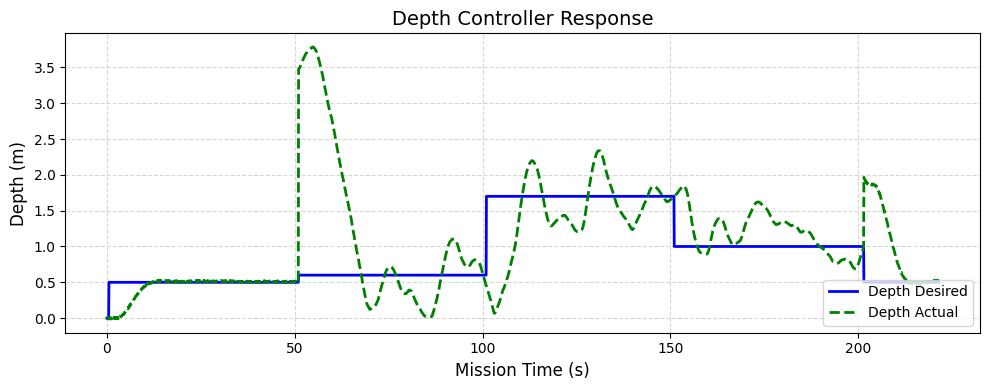

In [69]:

controls_debug = dfsByTopic["/controls/debug"]
cropped_df = controls_debug.iloc[start_crop:end_crop]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
y1 = cropped_df["depth.desired"].to_numpy()
y2 = cropped_df["depth.actual"].to_numpy()
y3 = cropped_df["depth.reference"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Depth Desired', color='blue', linewidth=2)
ax.plot(x, y2, label='Depth Actual', color='green', linewidth=2, linestyle='--')
# ax.plot(x, y3, label='Depth Reference', color='red', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Depth Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Depth (m)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()


/tmp/ipykernel_46532/2811650660.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()


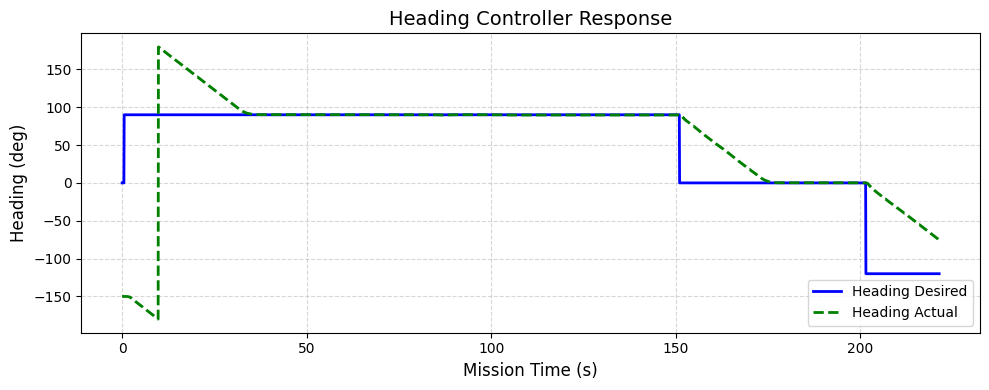

In [70]:

controls_debug = dfsByTopic["/controls/debug"]
cropped_df = controls_debug.iloc[start_crop:end_crop]

# Convert timestamp to seconds since mission start
start_time = cropped_df["timestamp"].iloc[0]
cropped_df["time_sec"] = (cropped_df["timestamp"] - start_time).dt.total_seconds()

# Extract data
x = cropped_df["time_sec"].to_numpy()
y1 = cropped_df["heading.desired"].to_numpy()
y2 = cropped_df["heading.actual"].to_numpy()

# Plot
fig, ax = plt.subplots(figsize=(10, 4))

ax.plot(x, y1, label='Heading Desired', color='blue', linewidth=2)
ax.plot(x, y2, label='Heading Actual', color='green', linewidth=2, linestyle='--')

# Labels and formatting
ax.set_title('Heading Controller Response', fontsize=14)
ax.set_xlabel('Mission Time (s)', fontsize=12)
ax.set_ylabel('Heading (deg)', fontsize=12)
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right', fontsize=10)

plt.tight_layout()
plt.show()
